# This is a starter notebook to help you start with the hackathon

# Large Language Model Challenge on [OHADA](https://www.ohada.org/) Law
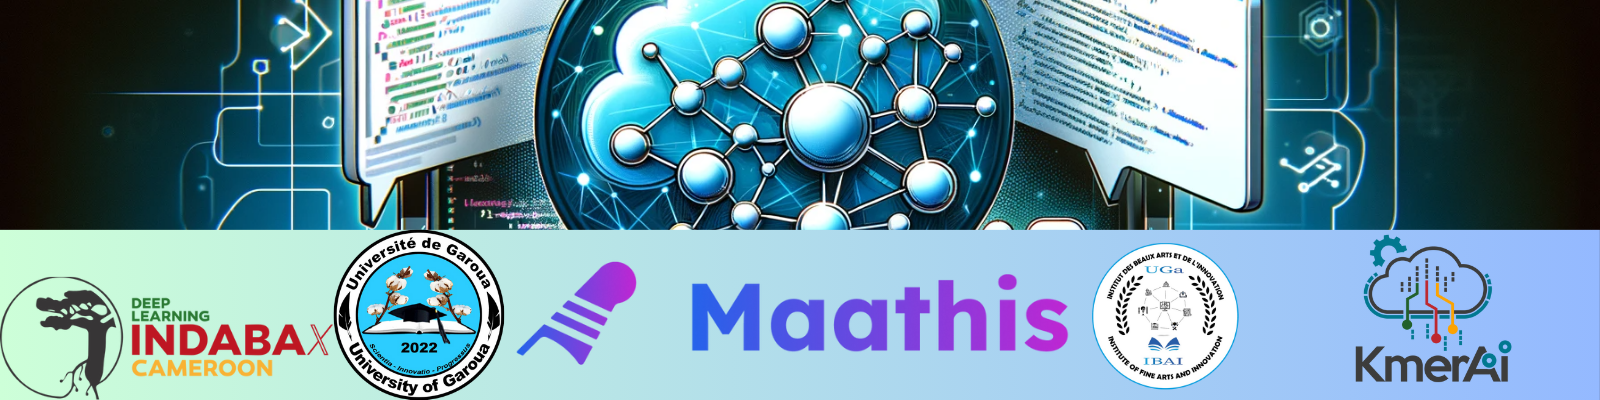

**[Inspired from the blog post by ai geek (wishesh)](https://levelup.gitconnected.com/building-a-private-ai-chatbot-2c071f6715ad)**

In [ ]:
#install required packages
%%capture
!pip install -q datasets transformers peft  accelerate bitsandbytes safetensors sentencepiece streamlit chromadb langchain sentence-transformers gradio

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig, pipeline
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.document_loaders import PyPDFDirectoryLoader
from langchain.chains import ConversationalRetrievalChain
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.memory import ConversationBufferMemory
from langchain.document_loaders import TextLoader
from langchain.llms import HuggingFacePipeline
from huggingface_hub import notebook_login
from langchain import HuggingFacePipeline
from langchain.vectorstores import Chroma
from datasets import load_dataset
import gradio as gr
import chromadb
import locale
import torch
import os

ModuleNotFoundError: No module named 'langchain'

In [ ]:
# fixing unicode error in google colab
locale.getpreferredencoding = lambda: "UTF-8"

In [ ]:
#Make sure to create a huggingface account and generate your token to login with here.
notebook_login()

# Load Model

In [ ]:
# specify model huggingface mode name
model_name = "meta-llama/Llama-2-7b-chat-hf"

###### other models:
# "Trelis/Llama-2-7b-chat-hf-sharded-bf16"
# "bn22/Mistral-7B-Instruct-v0.1-sharded"
# "mistralai/Mistral-7B-Instruct-v0.2"
# "HuggingFaceH4/zephyr-7b-beta"
# "anakin87/zephyr-7b-alpha-sharded"
# function for loading 4-bit quantized model

def load_quantized_model(model_name: str):
    """
    :param model_name: Name or path of the model to be loaded.
    :return: Loaded quantized model.
    """
    bnb_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_use_double_quant=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_dtype=torch.bfloat16
    )

    model = AutoModelForCausalLM.from_pretrained(
        model_name,
        #load_in_4bit=True,
        torch_dtype=torch.bfloat16,
        quantization_config=bnb_config
    )
    return model

# fucntion for initializing tokenizer
def initialize_tokenizer(model_name: str):
    """
    Initialize the tokenizer with the specified model_name.

    :param model_name: Name or path of the model for tokenizer initialization.
    :return: Initialized tokenizer.
    """
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    tokenizer.bos_token_id = 1  # Set beginning of sentence token id
    return tokenizer

In [ ]:
# load model
model = load_quantized_model(model_name)

# initialize tokenizer
tokenizer = initialize_tokenizer(model_name)

# specify stop token ids
stop_token_ids = [0]

config.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

`low_cpu_mem_usage` was None, now set to True since model is quantized.


model.safetensors.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/188 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.62k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

# Create Embeddings

###### Load data

#### Data have two formats: pdfs and jsons, here we will show you how to load the json files from hugginface or from a folder located in your drive. You have to load also the pdfs files and merge them with the json files to create your RAG.

In [ ]:
# load data from hugging face
%%capture
dataset = load_dataset("uriel/Maathis_Ohada_dataset", "default")

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['title', 'content', 'details'],
        num_rows: 1184
    })
})

In [ ]:
len(dataset['train'])

1184

In [ ]:
dataset['train'][0]['content']

'COUR COMMUNE DE JUSTICE ET ARBITRAGEDemande d\'avis n0 001/99Président du Tribunal Judiciairede Première Instance de Libreville(République Gabonaise)AVIS N° OO1/99/JN Séance du 7 juillet 1999\nLa Cour Commune de Justice et d\'Arbitrage, réunie en formation plénière à son siège le 7 juillet 1999,Vu le traité relatif à l\'harmonisation du Droit des Affaires en Afrique, notamment en ses articles 13 et 14 ; Vu le Règlement de procédure de la Cour Commune de Justice et d\'Arbitrage, notamment en ses articles 9,53,56,57 et 58 ;Vu la demande d\'avis formulée le 13 janvier 1999 par le Président du Tribunal judiciaire de première instance de Libreville (République Gabonaise), reçue le 1er mars 1999, dans une instance opposant la société X et Monsieur A à la société X et Monsieur B, et ainsi libellée :«...Donner son avis consultatif sur :1) Le régime juridique des nullités institué par l\'Acte uniforme (portant organisation des procédures simplifiées de recouvrement et des voies d\'exécution), 

In [ ]:
texts = []  # Initialize texts as an empty list to store file contents

for number in range(len(dataset['train'])):
    # if file.endswith('.json'):
    #     file_path = os.path.join(folder_path, file)
    #     with open(file_path, 'r', encoding='utf-8') as open_file:
        content = dataset['train'][number]['content']
        texts.append(content)

print(len(texts))

1184


###### Or

In [ ]:
# # mount google drive and specify folder path
# from google.colab import drive
# drive.mount('/content/drive')
# folder_path = '/content/drive/MyDrive/Garoua/Hackathon/data/' #change to data path in your drive
# texts = []  # Initialize texts as an empty list to store file contents

# for file in os.listdir(folder_path):
#     if file.endswith('.json'):
#         file_path = os.path.join(folder_path, file)
#         with open(file_path, 'r', encoding='utf-8') as open_file:
#             content = open_file.read()
#             texts.append(content)

# print(len(texts))


In [ ]:
class Document:
    def __init__(self, content, metadata=None):
        self.page_content = content
        # Initialize metadata as an empty dict if none provided
        self.metadata = metadata if metadata is not None else {}

In [ ]:
documents = [Document(content=text) for text in texts]
# split the documents in small chunks
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=100) #Chage the chunk_size and chunk_overlap as needed
all_splits = text_splitter.split_documents(documents)

In [ ]:
# specify embedding model (using huggingface sentence transformer)
embedding_model_name = "sentence-transformers/all-mpnet-base-v2"
model_kwargs = {"device": "cuda"}
embeddings = HuggingFaceEmbeddings(model_name=embedding_model_name, model_kwargs=model_kwargs)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
folder_path2 = '/content/drive/MyDrive/Vector_db/' #change to path in your drive where you want to store the vector db
# embed document chunks
# embeddings are stored in a database (presumably on disk) specified by persist_directory
# ensure that folder_path2 is correctly defined and points to a valid directory where you have write permissions
vectordb = Chroma.from_documents(documents=all_splits, embedding=embeddings, persist_directory= folder_path2 + "chroma_db")
retrieverts = vectordb.as_retriever()
#How to load
#vectordbts = Chroma(persist_directory= folder_path2 + "chroma_db", embedding_function=embeddings)

# Create Pipeline

In [ ]:
text_generation_pipeline = pipeline("text-generation", model=model,tokenizer=tokenizer,)

# specify the llm
llm = HuggingFacePipeline(pipeline=text_generation_pipeline)

def create_conversation(query: str, chat_history: list) -> tuple:
    try:
        # Object to hold the chat history
        memory = ConversationBufferMemory(
            memory_key='chat_history',
            return_messages=False
        )
        # chain setup
        qa_chain = ConversationalRetrievalChain.from_llm(
            llm=llm,
            retriever=retrieverts,
            memory=memory,
            get_chat_history=lambda h: h,
        )
        # get llm response with rag and history
        result = qa_chain({'question': query, 'chat_history': chat_history})
        # add the query and response to chat history
        chat_history.append((query, result['answer']))
        return '', chat_history

    # catch exceptions, log them into the chat history
    except Exception as e:
        chat_history.append((query, e))
        return '', chat_history

In [ ]:
test_query = "Qu'est-ce que l'OHADA ?"
test_history = []
create_conversation(test_query, test_history)

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:117: LangChainDeprecationWarning: The function `__call__` was deprecated in LangChain 0.1.0 and will be removed in 0.2.0. Use invoke instead.
  warn_deprecated(


('',
 [("Qu'est-ce que l'OHADA ?",
   "Use the following pieces of context to answer the question at the end. If you don't know the answer, just say that you don't know, don't try to make up an answer.\n\nLe Traité OHADA donne à la CCJA compétence pour statuer dès lors que le litige soulève des questions relatives à l’application des Actes uniformes ou des règlements prévus au Traité. Ainsi, la CCJA est compétente pour connaître d’un recours portant sur l’injonction de payer, quand bien même à côté des moyens de cassation ayant trait à l’AUPSRVE, d’autres moyens soulevés portent sur le droit interne (pourvois mixtes).Doit être considérée comme faite à la personne de la débitrice, s’agissant d’une personne morale, la signification d’une ordonnance d’injonction de payer faite à la secrétaire assistante de son représentant légal qui a reçu et déchargé l’acte en déclinant son identité. Ainsi, la date à prendre en considération comme point de départ du délai de quinze jours pour former oppo

#### As you can see, the answer provided by the model is in english, try to get the answer in French

# Prompt-Engineering

In [ ]:
test_query = "Qu'est-ce que l'OHADA ?"
test_prompt = f"""<s>[INST] {test_query}  [/INST] """
test_history = []
create_conversation(test_prompt, test_history)

('',
 [("<s>[INST] Qu'est-ce que l'OHADA ?  [/INST] ",
   "Use the following pieces of context to answer the question at the end. If you don't know the answer, just say that you don't know, don't try to make up an answer.\n\nLe Traité OHADA donne à la CCJA compétence pour statuer dès lors que le litige soulève des questions relatives à l’application des Actes uniformes ou des règlements prévus au Traité. Ainsi, la CCJA est compétente pour connaître d’un recours portant sur l’injonction de payer, quand bien même à côté des moyens de cassation ayant trait à l’AUPSRVE, d’autres moyens soulevés portent sur le droit interne (pourvois mixtes).Doit être considérée comme faite à la personne de la débitrice, s’agissant d’une personne morale, la signification d’une ordonnance d’injonction de payer faite à la secrétaire assistante de son représentant légal qui a reçu et déchargé l’acte en déclinant son identité. Ainsi, la date à prendre en considération comme point de départ du délai de quinze jo

# Gradio UI

In [ ]:
# build gradio ui
with gr.Blocks() as demo:

    chatbot = gr.Chatbot(label='Chat with your Ohada dataset ;)')
    msg = gr.Textbox()
    clear = gr.ClearButton([msg, chatbot])

    msg.submit(create_conversation, [msg, chatbot], [msg, chatbot])

demo.launch()

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://a06d480ded2e92e485.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


### Good Luck for the Competition !!!!

### Be creative!!!